# Building ML model


## Content

- Preparation
    - Load data
    - Data preprocessing


- Out-of-sample error estimation
    - Train-test split
    - Cross-Validation


- Tuning hyperparameters for different models
    - Logistic regression
    - k-Nearest Neighbors
    - SVM
    - Fitting models on scaled data

    
- Analyzing performance
    - Comparing results
    - Accuracy, precision, recall
    - PR curve and ROC
    
    
- Bayesian Optimization

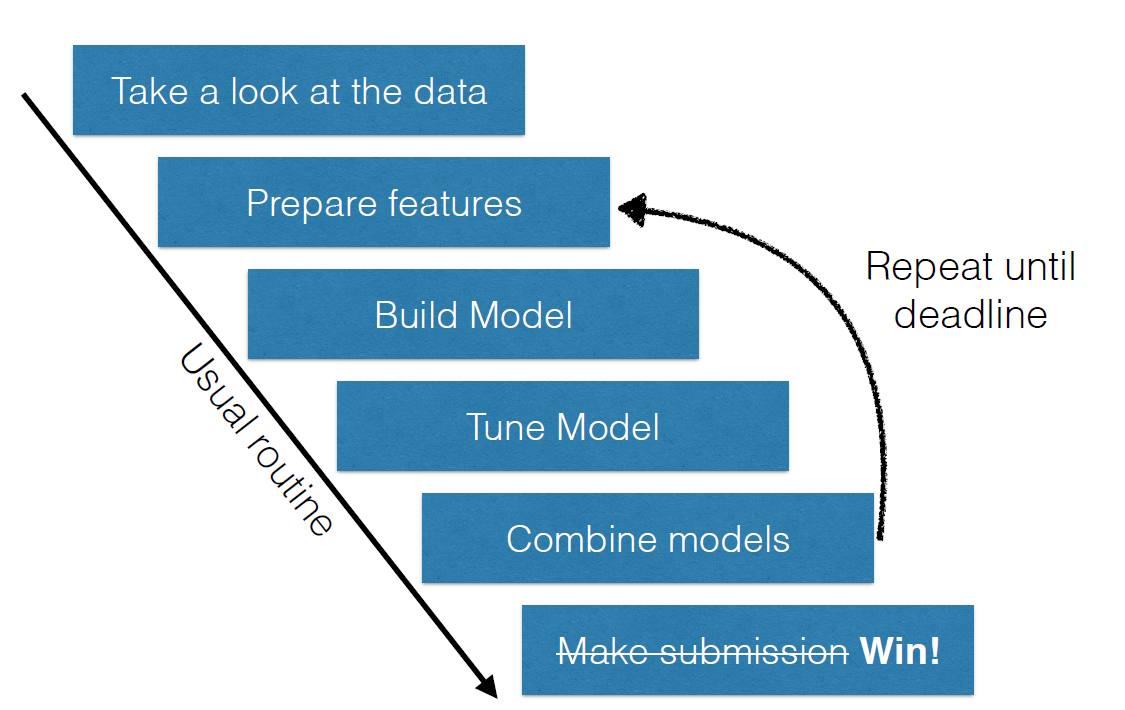

In [130]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Preparation

## Read data

In [131]:
df = pd.read_csv(r'C:\Users\310\Desktop\Progects_Py\ML-course-at-ICEF\data\german_credit_data_train.csv')

print(df.shape)
df.head()

(900, 10)


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


###### Select numerical and categorical variables and target

We do this, because we need to treat numerical and categorical variables and target differently
- numerical -- we can check their distributions, remove outliers etc.
- categorical -- we need transform them into numerical somehow
- target -- encode and ensure that we do not have leakeges

In [132]:
num = ['Age', 'Credit amount', 'Duration']
cat = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
target = 'Risk'

In [133]:
df[num].head()

,Age,Credit amount,Duration
0,67,1169,6
1,22,5951,48
2,49,2096,12
3,45,7882,42
4,53,4870,24


In [134]:
df[cat].head()

,Sex,Job,Housing,Saving accounts,Checking account,Purpose
0,male,2,own,NaN,little,radio/TV
1,female,2,own,little,moderate,radio/TV
2,male,1,own,little,NaN,education
3,male,2,free,little,little,furniture/equipment
4,male,2,free,little,little,car


In [135]:
df[target].value_counts(normalize=True)

Risk
good    0.702222
bad     0.297778
Name: proportion, dtype: float64

## Data preprocessing

###### Transform target to 0 and 1

In [136]:
df[target] = df[target].map({'good': 0, 'bad': 1})

df[target].head()

0    0
1    1
2    0
3    0
4    1
Name: Risk, dtype: int64

In [137]:
df[target].mean()

0.29777777777777775

###### Fill missing values

In [138]:
df['Saving accounts'] = df['Saving accounts'].fillna('Unknown')
df['Checking account'] = df['Checking account'].fillna('Unknown')

###### Encoding of categorical features

- use get_dummies only for categorical columns

In [139]:
df = pd.get_dummies(data=df, columns=cat, drop_first=True)

df.head()

,Age,Credit amount,Duration,Risk,Sex_male,Job_1,Job_2,Job_3,Housing_own,Housing_rent,...,Checking account_little,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,67,1169,6,0,True,False,True,False,True,False,...,True,False,False,False,False,False,False,True,False,False
1,22,5951,48,1,False,False,True,False,True,False,...,False,True,False,False,False,False,False,True,False,False
2,49,2096,12,0,True,True,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
3,45,7882,42,0,True,False,True,False,False,False,...,True,False,False,False,False,False,True,False,False,False
4,53,4870,24,1,True,False,True,False,False,False,...,True,False,False,True,False,False,False,False,False,False


In [140]:
df.groupby('Sex_male').agg({target: 'mean'})

,Risk
Sex_male,
False,0.358156
True,0.270227


###### Choose features for training

In [141]:
train_cols = df.columns.difference([target])

train_cols

Index(['Age', 'Checking account_little', 'Checking account_moderate',
       'Checking account_rich', 'Credit amount', 'Duration', 'Housing_own',
       'Housing_rent', 'Job_1', 'Job_2', 'Job_3', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Saving accounts_little',
       'Saving accounts_moderate', 'Saving accounts_quite rich',
       'Saving accounts_rich', 'Sex_male'],
      dtype='object')

In [122]:
X = df[train_cols]
y = df[target]

In [142]:
X

,Age,Checking account_little,Checking account_moderate,Checking account_rich,Credit amount,Duration,Housing_own,Housing_rent,Job_1,Job_2,...,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Saving accounts_little,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Sex_male
0,67,True,False,False,1169,6,True,False,False,True,...,False,False,True,False,False,False,False,False,False,True
1,22,False,True,False,5951,48,True,False,False,True,...,False,False,True,False,False,True,False,False,False,False
2,49,False,False,False,2096,12,True,False,True,False,...,True,False,False,False,False,True,False,False,False,True
3,45,True,False,False,7882,42,False,False,False,True,...,False,True,False,False,False,True,False,False,False,True
4,53,True,False,False,4870,24,False,False,False,True,...,False,False,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,31,False,False,False,8947,36,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
896,28,True,False,False,2606,21,False,True,False,False,...,False,False,True,False,False,True,False,False,False,False
897,35,False,False,False,1592,12,True,False,False,True,...,False,True,False,False,False,False,False,False,True,False
898,33,False,False,False,2186,15,False,True,True,False,...,False,True,False,False,False,False,False,False,False,False


# Out-of-sample error estimation

https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6

## Train-val split

### Full scheme:

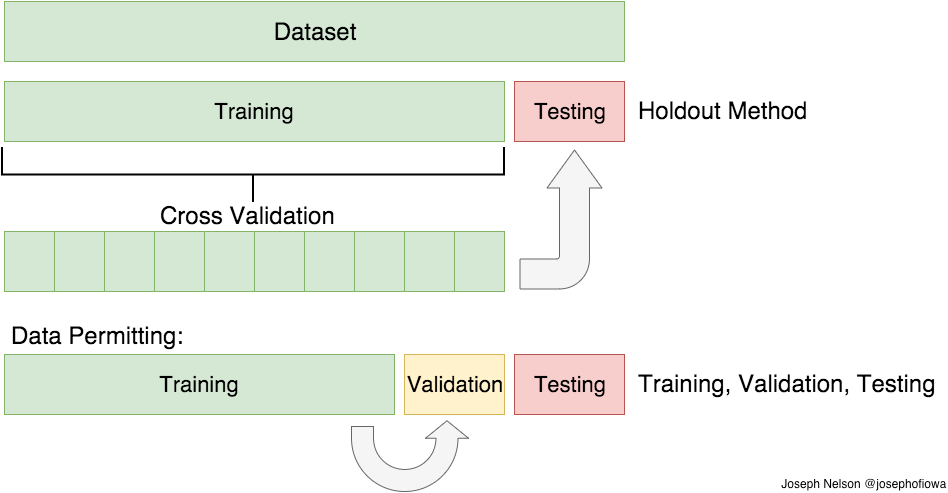

In [145]:
from sklearn.model_selection import train_test_split

Xtr, Xval, ytr, yval = train_test_split( X, y, test_size=0.15, random_state=15)

In [146]:
Xtr

,Age,Checking account_little,Checking account_moderate,Checking account_rich,Credit amount,Duration,Housing_own,Housing_rent,Job_1,Job_2,...,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Saving accounts_little,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Sex_male
473,36,False,False,False,1238,6,True,False,False,False,...,True,False,False,False,False,False,False,False,False,True
523,23,False,False,False,3488,24,True,False,False,True,...,False,False,False,False,False,False,True,False,False,False
748,26,False,False,False,5248,21,True,False,False,True,...,False,False,False,False,False,False,False,False,False,True
623,22,True,False,False,1858,12,False,True,False,True,...,False,True,False,False,False,True,False,False,False,False
867,42,False,False,False,3331,12,True,False,False,True,...,False,True,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,26,False,False,False,4272,30,True,False,True,False,...,False,False,False,False,False,False,True,False,False,True
887,23,False,True,False,15672,48,True,False,False,True,...,False,False,False,False,False,True,False,False,False,True
645,27,False,False,False,7980,36,False,True,False,True,...,False,False,False,False,False,False,False,False,False,True
757,39,False,False,True,1271,15,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True


## Cross-Validation


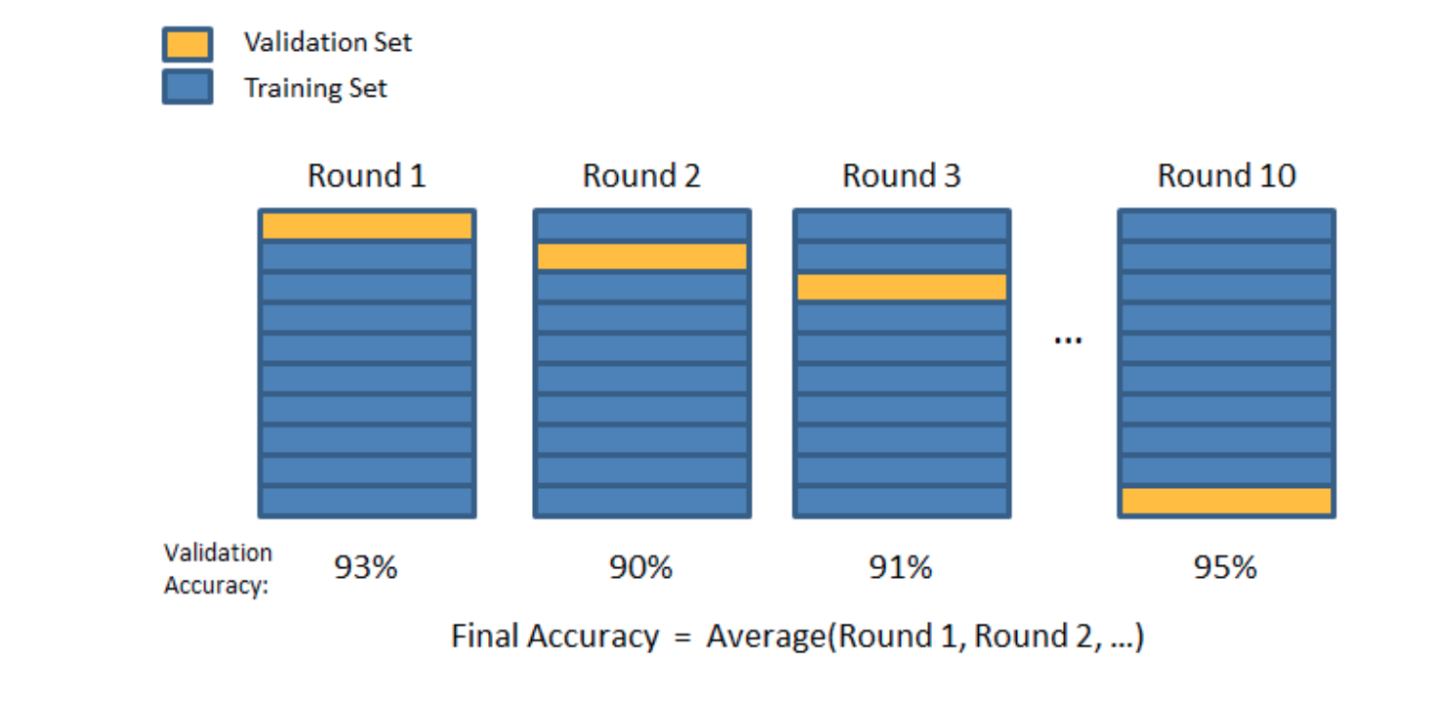

In [94]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=25)

# Tuning hyperparameters for different "simple" models

## Logistic Regression

The model:

$$p(x) = \frac{e^{\beta_0 + \beta_1 x_1 + \beta_2 x_2 \dots }}{1 + e^{\beta_0 + \beta_1 x_1 + \beta_2 x_2 \dots }} = sigmoid(\beta_0 + \beta_1 x_1 + \beta_2 x_2 \dots)$$

In short, the model is simply [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) applied to the output of a linear model.


Pros:
- simple
- interpretable
- allow inference

Cons:
- assumptions of logistic regression

Hyperparameters:
- C -- Inverse of $l_1$ or $l_2$ regularization strength; smaller values specify stronger regularization
- penalty -- the norm used in the penalization ($l_1$, $l_2$ or combination)

#### Task: fit logreg and calculate accuracy score for validation dataset and using CV

In [147]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X=Xtr, y=ytr)

LogisticRegression()

In [29]:
predicted_probabilities = model.predict_proba(Xval)[:, 1]

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [60]:
from sklearn.metrics import roc_auc_score

score = pass

print('Score: {:.2f}'.format(score))

Score: 0.69


In [61]:
from sklearn.model_selection import cross_val_score

model = LogisticRegression(C=0.01)

scores = pass

print('Scores on CV folds:', scores, '\n')
print('Average score on CV folds: {:.2f}'.format(np.mean(scores)))
print('Std of score on CV folds: {:.2f}'.format(np.std(scores)))

Scores on CV folds: [0.70873206 0.70422108 0.67172791 0.59550562 0.73732159] 

Average score on CV folds: 0.68
Std of score on CV folds: 0.05


#### Task: find best hyperparameter for C in logreg using Grid Search using roc-auc scoring

In [83]:
from sklearn.model_selection import GridSearchCV

pass

GS_LR = pass

GS_LR.fit(Xtr, ytr)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(),
             param_grid={'C': array([0.001     , 0.00143845, 0.00206914, 0.00297635, 0.00428133,
       0.00615848, 0.00885867, 0.01274275, 0.01832981, 0.02636651,
       0.0379269 , 0.05455595, 0.078476  , 0.11288379, 0.16237767,
       0.23357215, 0.33598183, 0.48329302, 0.6951928 , 1.        ])},
             scoring='roc_auc')

#### Task: print best C and corresponding best score

In [84]:
best_C = pass
best_roc_auc = pass

print('Best C {:.3f}'.format(best_C))
print('Best ROC AUC {:.3f}'.format(best_roc_auc))

Best C 0.336
Best ROC AUC 0.763


#### Task: plot mean and std of scores after CV

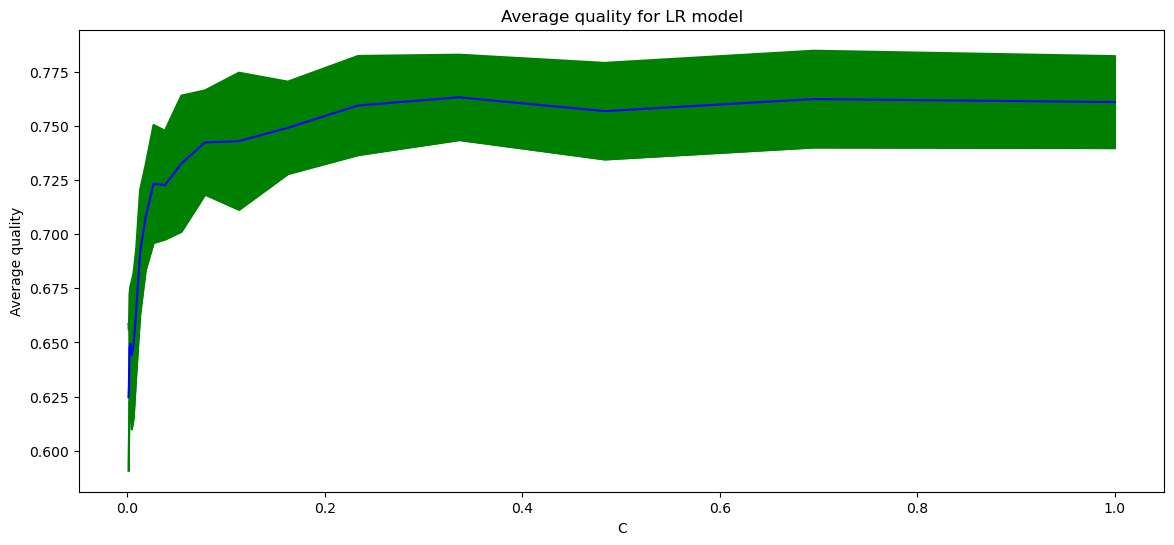

In [85]:
means = pass
stds = pass
error = 0.5 * stds

plt.figure(figsize=(14, 6))
plt.plot(params['C'], means, color = 'blue')
plt.plot(params['C'], means - error, color = 'green')
plt.plot(params['C'], means + error, color = 'green')
plt.fill_between(params['C'], means - error, means + error, color = 'green')
plt.xlabel('C')
plt.ylabel('Average quality')
plt.title('Average quality for LR model')
plt.show()

In [86]:
best_model = GS_LR.best_estimator_

## k-Nearest Neighbors


K – Nearest Neighbours is a non – linear classifier (and hence, the prediction boundary is non-linear) that predicts which class a new test data point belongs to by identifying its k nearest neighbors’ class. We select these k nearest neighbors based on Euclidean distance. Among these k neighbours, the number of data points in each category is counted, and the new data point is assigned to that category where we got the most neighbours in.

Prediction:
 $$\hat{f}(x_i) = \frac{1}{k}\sum_{j \in N(x_i)}y_j$$

Pros:
- simple
- very non-linear
- can be used for feature engineering

Cons:
- not efficient when data is big
- no inference

Hyperparameters:
- n_neighbors
- weights -- uniform or distance

#### Task: find best hyperparameter for KNN using Random Search

In [188]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV



param_grid = {
    'n_neighbors' : np.arange(10),
    'weights': ['uniform', 'distance']
}

RS_kNN = RandomizedSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='roc_auc')


In [189]:
RS_kNN.fit(X=Xtr, y=ytr)

RandomizedSearchCV(cv=10, estimator=KNeighborsClassifier(),
                   param_distributions={'n_neighbors': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'weights': ['uniform', 'distance']},
                   scoring='roc_auc')

In [190]:
print('Best n_neighbors {:.3f}'.format(RS_kNN.best_params_['n_neighbors']))
print('Best ROC AUC {:.3f}'.format(RS_kNN.best_score_))

Best n_neighbors 7.000
Best ROC AUC 0.563


In [191]:
means

array([0.54428664, 0.54796794, 0.56307424, 0.55714725, 0.54485917,
       0.54967357,        nan, 0.54937791, 0.54168718, 0.54580941])

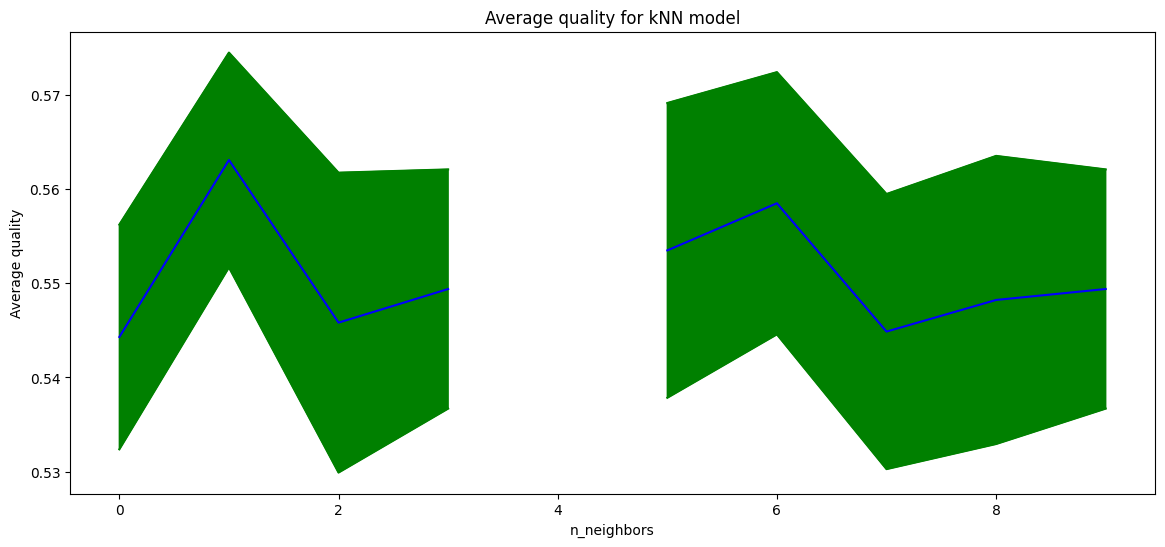

In [192]:
means = RS_kNN.cv_results_['mean_test_score']
stds = RS_kNN.cv_results_['std_test_score']
error = 0.2 * stds

plt.figure(figsize=(14, 6))
plt.plot(param_grid['n_neighbors'], means, color = 'blue')
plt.plot(param_grid['n_neighbors'], means - error, color = 'green')
plt.plot(param_grid['n_neighbors'], means + error, color = 'green')
plt.fill_between(param_grid['n_neighbors'], means - error, means + error, color = 'green')
plt.xlabel('n_neighbors')
plt.ylabel('Average quality')
plt.title('Average quality for kNN model')
plt.show()

### Support vector machines (SVMs)

SVMs are a set of supervised learning methods used for classification, regression and outliers detection.

\begin{equation}
\label{eq:svmUnsep}
    \left\{
        \begin{aligned}
            & \frac{1}{2} \|w\|^2 + C \sum_{i = 1}^{\ell} \xi_i \to \min_{w, b, \xi} \\
            & y_i \left(
                \langle w, x_i \rangle + b
            \right) \geq 1 - \xi_i, \quad i = 1, \dots, \ell, \\
            & \xi_i \geq 0, \quad i = 1, \dots, \ell.
        \end{aligned}
    \right.
\end{equation}

The advantages of support vector machines are:

- Effective in high dimensional spaces.
- Still effective in cases where number of dimensions is greater than the number of samples.
- Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.

Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.


The disadvantages of support vector machines include:

- If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.
- SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation.

Hyperparameters:
- C: regularization
- kernel: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} 
- degree, gamma, coef0

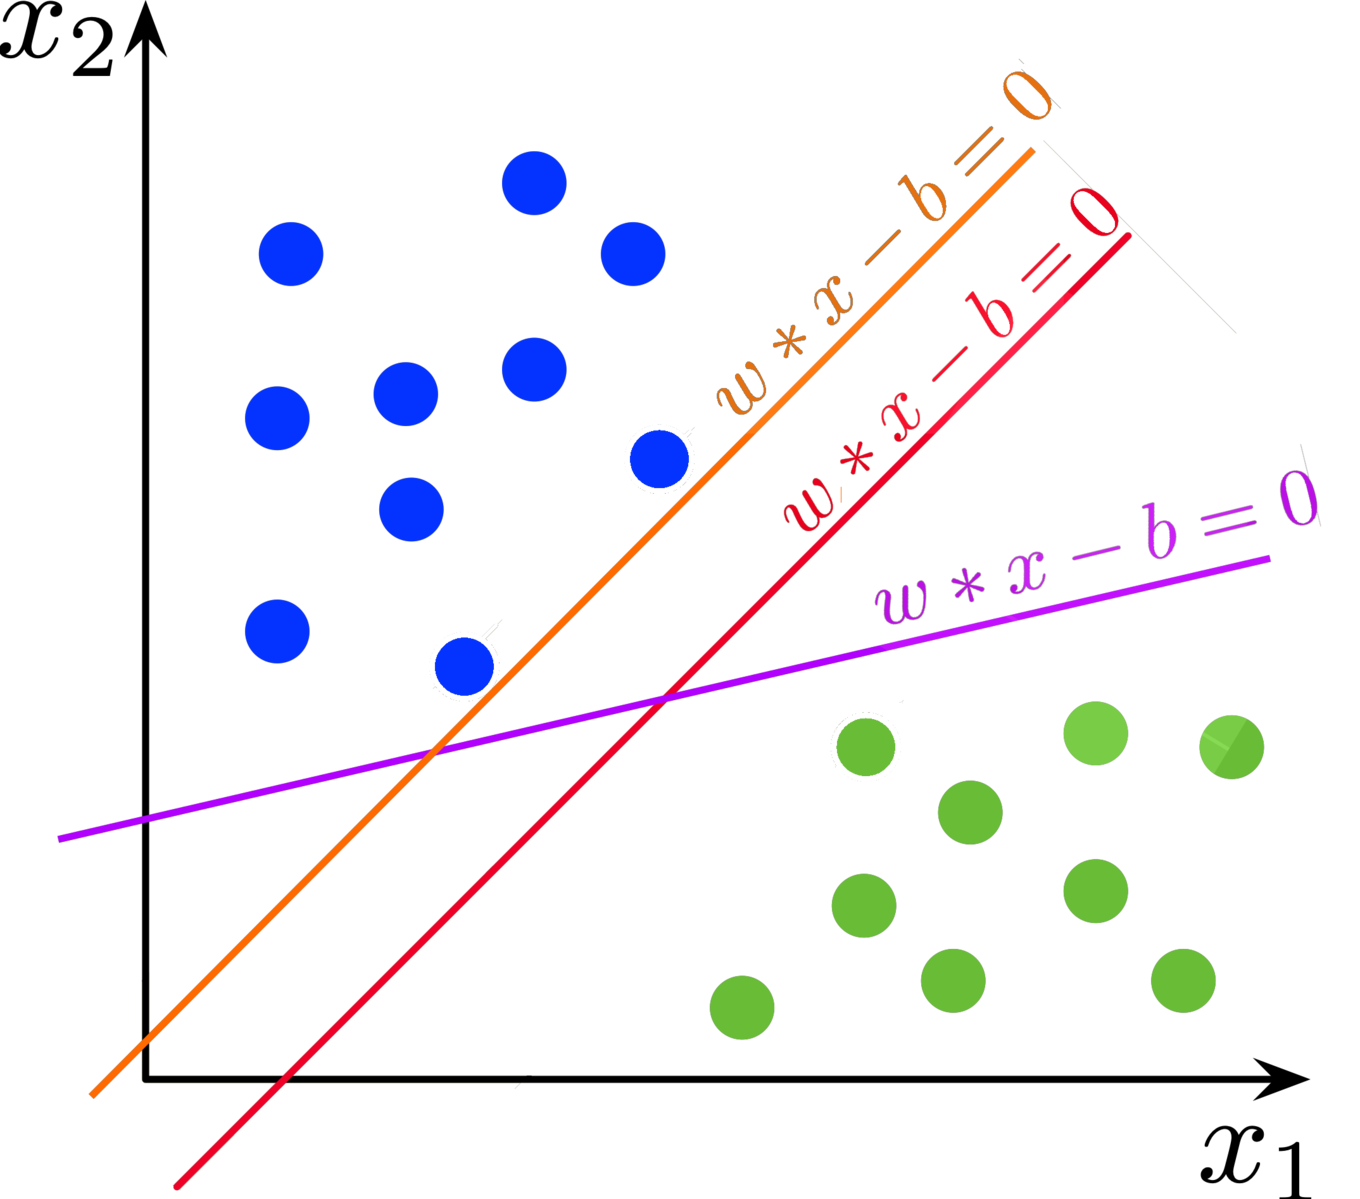

#### Task: do the same exercise with SVC
try to find better boundaries for HP 

In [165]:
from sklearn.svm import SVC

pass


GS_svc = GridSearchCV(
    pass
)

In [166]:
GS_svc.fit(X=Xtr, y=ytr)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(probability=True),
             param_grid={'C': array([0.001     , 0.00143845, 0.00206914, 0.00297635, 0.00428133,
       0.00615848, 0.00885867, 0.01274275, 0.01832981, 0.02636651,
       0.0379269 , 0.05455595, 0.078476  , 0.11288379, 0.16237767,
       0.23357215, 0.33598183, 0.48329302, 0.6951928 , 1.        ]),
                         'kernel': ['rbf', 'poly']},
             scoring='roc_auc')

In [167]:
GS_svc.best_estimator_

SVC(C=0.6951927961775606, kernel='poly', probability=True)

In [168]:
print('Best C {:.3f}'.format(GS_svc.best_params_['C']))
print('Best ROC AUC {:.3f}'.format(GS_svc.best_score_))

Best C 0.695
Best ROC AUC 0.569


#### Task: plot graphs of SVM quality for every C for every kernel function

# Data rescaling

In [148]:
from sklearn.preprocessing import StandardScaler

ss = pass

X_scaled = pass
X_val_scaled = pass

In [150]:
model = KNeighborsClassifier()


GS_kNN.fit(pass)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 100, 2)}, scoring='roc_auc')

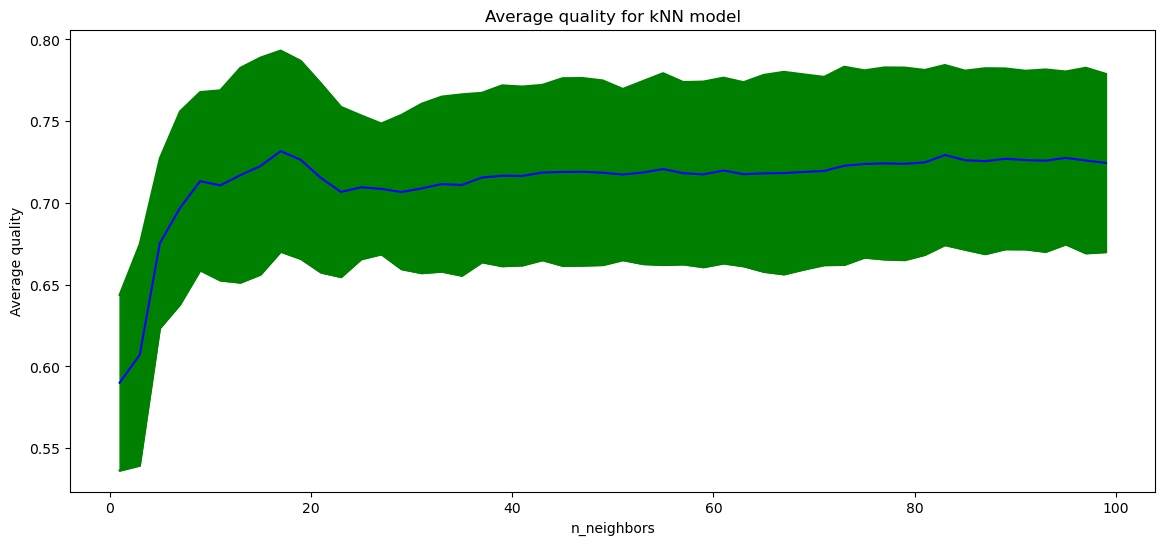

In [151]:
means = pass
stds = pass
error = 1.2 * stds

plt.figure(figsize=(14, 6))
plt.plot(params['n_neighbors'], means, color = 'blue')
plt.plot(params['n_neighbors'], means - error, color = 'green')
plt.plot(params['n_neighbors'], means + error, color = 'green')
plt.fill_between(params['n_neighbors'], means - error, means + error, color = 'green')
plt.xlabel('n_neighbors')
plt.ylabel('Average quality')
plt.title('Average quality for kNN model')
plt.show()

#### Task: fit logreg and SVC on scaled data, compare the results. Do these algorithms perform better after scaling?

# Analyzing performance

- remember what we discussed during previous class
- add lines for precision_recall_curve and roc_curve

In [170]:
kNN_model = RS_kNN.best_estimator_ 
LR_model = GS_LR.best_estimator_ 
SVC_model = GS_svc.best_estimator_

## Different metrics for binary classification

Finally, we can plot the **confusion matrix** of our test predictions.

![image.png](https://glassboxmedicine.files.wordpress.com/2019/02/confusion-matrix.png?w=816)

Confusion matrix is a nececary tool for analysing a classifier performance.

It allows us to compute [different metrics of performance](https://en.wikipedia.org/wiki/Precision_and_recall) such as:

**Accuracy**: $(TP + TN)/(TP + TN + FP + FN)$ -- the fraction of predictions our model got right

**Precision**: $TP/ (TP + FP)$ -- What proportion of positive identifications was actually correct?

**Recall**: $TP / (TP + FN)$ -- What proportion of actual positives was identified correctly?

[**Balanced accuracy** (resistant to class imbalance)](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score)

In [153]:
from sklearn.metrics import confusion_matrix, classification_report

In [161]:
print('kNN')
print(classification_report(yval, kNN_model.predict(pass)))

print('\nLogistic regression')
print(classification_report(yval, LR_model.predict(pass)))

print('\nSVC')
print(classification_report(yval, SVC_model.predict(pass)))

kNN
              precision    recall  f1-score   support

           0       0.71      0.95      0.82       188
           1       0.53      0.12      0.20        82

    accuracy                           0.70       270
   macro avg       0.62      0.54      0.51       270
weighted avg       0.66      0.70      0.63       270


Logistic regression
              precision    recall  f1-score   support

           0       0.75      0.87      0.81       188
           1       0.54      0.34      0.42        82

    accuracy                           0.71       270
   macro avg       0.65      0.61      0.61       270
weighted avg       0.69      0.71      0.69       270


SVC
              precision    recall  f1-score   support

           0       0.70      1.00      0.82       188
           1       0.00      0.00      0.00        82

    accuracy                           0.70       270
   macro avg       0.35      0.50      0.41       270
weighted avg       0.48      0.70      0.57 

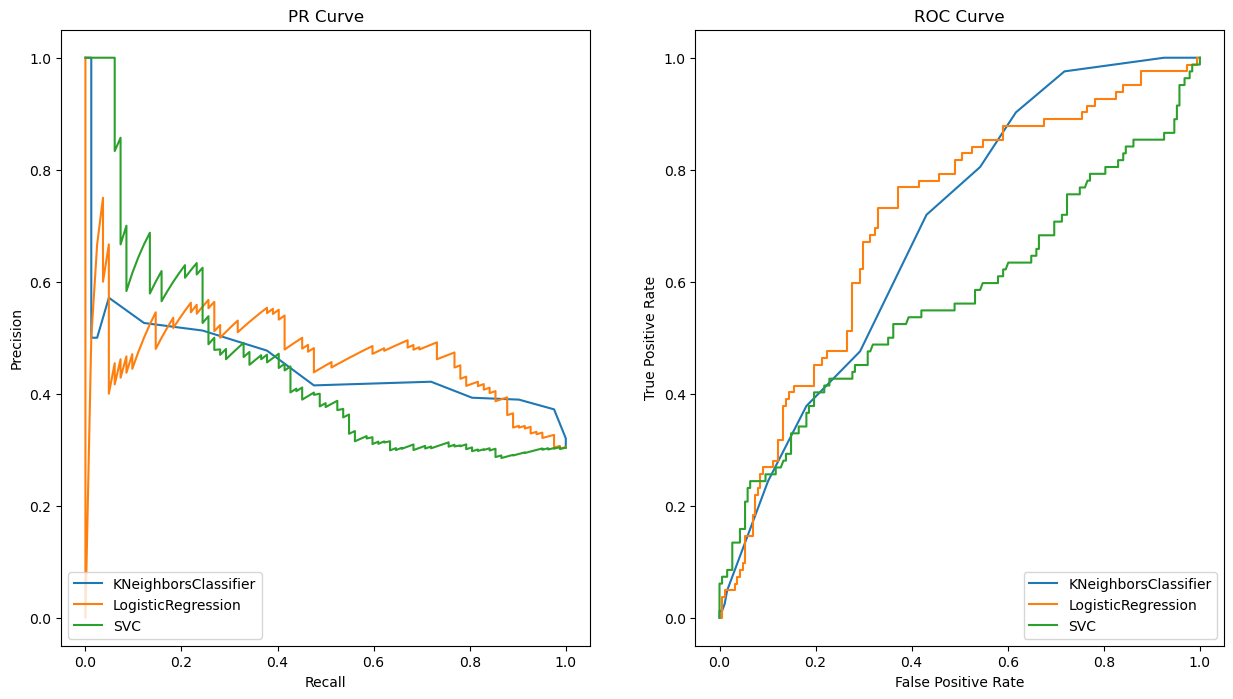

In [171]:
from sklearn.metrics import precision_recall_curve, roc_curve

fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')
    
for model in [kNN_model, LR_model, SVC_model]:
    
    scores = pass
    
    p, r, _ = pass
    tpr, fpr, _ = pass
    
    ax1.plot(r,p,label=model.__class__.__name__) 
    ax2.plot(tpr,fpr,label=model.__class__.__name__)


ax1.legend(loc='lower left')    
ax2.legend(loc='lower right')
                                          
plt.show()

## Bayesian optimization

Random and grid search pay no attention to past results when searhing the best hyperparametes. Bayesian optimization, in contrast to random or grid search, keeps track of past evaluation results which it uses to form a probabilistic model mapping hyperparameters to a probability of a score on the objective function. There're a number of libraries that can do it. The 2 popular examples of such libraries:  [optuna](https://github.com/optuna/optuna) and [hyperopt](https://github.com/hyperopt/hyperopt).

#### Task: find optimal parameters using optuna optimization
Here's just a template, please refer to documentation to create working code

In [ ]:
import optuna
from optuna.samplers import TPESampler


def objective(trial):
    params = {
        pass
    }

    model = pass
    model.fit(pass)
    y_pred = model.predict_proba(Xval)[:, 1]
    return roc_auc_score(yval, y_pred)

sampler = TPESampler(seed=123)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=20)

#### Task: compare all models on validation data (with and without scaling), write which models are the best and which HP optimization technique works better in this task